In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline

In [1]:
import os
import logging
from functools import partial

from jax import random
from torchvision import transforms
import wandb
from flax.training.checkpoints import save_checkpoint, restore_checkpoint

from src.models import make_Hard_OvR_Ens_loss as make_prod_loss
from src.models import make_Hard_OvR_Ens_MNIST_plots as make_plots
from src.models import make_Cls_Ens_loss as make_ens_loss
from src.data import get_image_dataset, NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.mnist_hard_ovr_classification import get_config

from operator import itemgetter

2022-10-13 17:35:41.515640: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 17:35:42.270442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-13 17:35:42.270519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-13 17:35:42.270527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
arg_max_python_list = lambda items: max(enumerate(items), key=itemgetter(1))[0]
arg_min_python_list = lambda items: min(enumerate(items), key=itemgetter(1))[0]

In [4]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'cls_comparison_figures.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: metodj. Use `wandb login --relogin` to force relogin


True

In [6]:
N_RANDOM_SEEDS = 1

In [7]:
config = get_config()

In [8]:
train_dataset, _, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
ens_train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
ens_val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)

train_dataset, test_dataset, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)
test_loader = NumpyLoader(test_dataset, config.batch_size, num_workers=8)

In [9]:
ens_config = config.copy_and_resolve_references()
ens_config.model_name = 'Cls_Ens'
del ens_config.β_schedule

In [25]:
best_ens_states = []
best_prod_states = []

RECOMPUTE_PROD = True
RECOMPUTE_ENS = False
RECOMPUTE_PROD_STD = False
PRETRAIN_PROD = True

for i in range(0, N_RANDOM_SEEDS):
    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)
    init_x = train_dataset[0][0]
    init_y = train_dataset[0][1]

    ens_model, state = setup_training(ens_config, setup_rng, init_x, init_y)

    if RECOMPUTE_ENS:
        _, ens_state = train_loop(
            ens_model, state, ens_config, rng, make_ens_loss, make_ens_loss, ens_train_loader, ens_val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': 'Data augmentation',
                # 'tags': ['MNIST testing'],
            },
            # plot_fn=make_plots,
            # plot_freq=1,
        )

        save_checkpoint(f'dynNN_redux/ens_model_{i}', ens_state, 1, overwrite=True)

    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)

    prod_model, state = setup_training(config, setup_rng, init_x, init_y)

    if RECOMPUTE_PROD:
        if PRETRAIN_PROD:
            
            # state.replace(params=ens_state.params)
            state = state.replace(params=ens_state.params)
            # TODO: Also replace BN (model) state?

        _, prod_state = train_loop(
            prod_model, state, config, rng, partial(make_prod_loss, per_member_loss=0.5), partial(make_prod_loss, per_member_loss=0.5), train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': 'pre-trained',
                # 'tags': ['MNIST testing', 'pre-trained'],
            },
            # plot_fn=make_plots,
            # plot_freq=1,
        )

        save_checkpoint(f'dynNN_redux/prod_model_{i}', prod_state, 1, overwrite=True)

    stdprod_model, state = setup_training(config, setup_rng, init_x, init_y)

    if RECOMPUTE_PROD_STD:
        rng = random.PRNGKey(i)
        setup_rng, rng = random.split(rng)

        _, stdprod_state = train_loop(
            stdprod_model, state, config, rng, partial(make_prod_loss, per_member_loss=0.00), partial(make_prod_loss, per_member_loss=0.00), train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': 'pre-trained',
                # 'tags': ['MNIST testing', 'pre-trained'],
            },
            # plot_fn=make_plots,
            # plot_freq=1,
        )

        save_checkpoint(f'dynNN_redux/stdprod_model_{i}', stdprod_state, 1, overwrite=True)

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

FrozenDict({
    nets_0: {
        input_layer: {
            bias: DeviceArray([-0.67543346, -0.10183772,  0.7592932 , -0.88525826,
                         -0.56728745,  0.28170758, -0.5467698 , -0.07602456,
                         -0.8632413 ,  0.11609279, -0.31139874,  0.8916477 ,
                          0.10696848, -0.49004543,  0.6784051 , -0.17926806,
                         -0.24773285,  0.53747004,  0.11839904, -0.4864103 ,
                          0.04144078,  0.24473535, -0.84682214,  0.5331708 ,
                          0.88628495, -0.40148625,  0.32599038, -0.37605593,
                         -0.71300775, -0.9468981 , -0.66300726, -0.00355381,
                         -0.22125863, -0.7676347 , -0.03561416,  0.912429  ,
                         -0.4211224 , -0.80037147,  0.23154645,  0.6141011 ,
                          0.705338  , -0.2501582 , -0.3955001 , -0.41989717,
                         -0.2345342 ,  0.3758156 , -0.15173887, -0.16420214,
                    

2022-10-13 17:26:19.723589: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 17:26:20.328610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-13 17:26:20.328726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-13 17:26:20.328734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/50 [00:00<?, ?it/s]

epoch:   1 - train loss: 0.07410, val loss: 0.27325, train err: 0.0034, val err: 0.0205, β: 2.1141, lr: 0.00360
epoch:   2 - train loss: 0.07277, val loss: 0.27243, train err: 0.0029, val err: 0.0207, β: 2.1391, lr: 0.00420
epoch:   3 - train loss: 0.07078, val loss: 0.27191, train err: 0.0026, val err: 0.0208, β: 2.1695, lr: 0.00480
epoch:   4 - train loss: 0.06884, val loss: 0.27303, train err: 0.0026, val err: 0.0218, β: 2.2065, lr: 0.00540
epoch:   5 - train loss: 0.06568, val loss: 0.26985, train err: 0.0024, val err: 0.0217, β: 2.2513, lr: 0.00600
epoch:   6 - train loss: 0.06476, val loss: 0.28627, train err: 0.0025, val err: 0.0202, β: 2.3058, lr: 0.00660
epoch:   7 - train loss: 0.06353, val loss: 0.30989, train err: 0.0019, val err: 0.0203, β: 2.3717, lr: 0.00720
epoch:   8 - train loss: 0.06159, val loss: 0.27295, train err: 0.0019, val err: 0.0202, β: 2.4513, lr: 0.00780
epoch:   9 - train loss: 0.06055, val loss: 0.28378, train err: 0.0021, val err: 0.0208, β: 2.5473, lr: 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▄▄▅▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train/err,█▇▆▆▆▅▅▅▄▄▄▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁
train/loss,███▇▇▇▇▆▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/err,▂▃▃▅▁▂▁▃▃▄▂▃▂▄▇█▄▂▂▃▁▁▁▄█▃▃▁▃▄▆▄▄▅▅▃▄▄▃▄
val/loss,▁▁▁▁▄█▁▃▃▂▂▂▁▂▂▁▂▂▂▁▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
β,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇██████████
best_epoch,49
best_val_err,0.02067
epoch,50
learning_rate,0.0003


+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

## Paper plots

In [34]:
from  functools import partial
from itertools import combinations

import matplotlib
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import distrax
from chex import assert_rank, assert_shape, assert_equal_shape

from math import comb

In [35]:
restored_prod_models = [restore_checkpoint(f'dynNN_redux/prod_model_{i}', 1) for i in range(3)] # 3
restored_ens_models = [restore_checkpoint(f'dynNN_redux/ens_model_{i}', 1) for i in range(3)] # 3
restored_stdprod_models = [restore_checkpoint(f'dynNN_redux/stdprod_model_{i}', 1) for i in range(3)] # 3

In [36]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_17642/821981954.py:20: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [37]:
X_test, y_test = list(zip(*test_loader.dataset))

In [38]:
len(X_test)

10000

In [39]:
len(y_test)

10000

In [40]:
def categorical_probs(logits):
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    probs = nn.softmax(logits.mean(axis=0))
    assert_shape([probs], (10,))
    return probs

def categorical_entropy(logits):
    probs = categorical_probs(logits)
    cat = distrax.Categorical(probs=probs)
    return cat.entropy()

def categorical_nll(logits, y):
    probs = categorical_probs(logits).clip(min=1e-36)
    cat = distrax.Categorical(probs=probs)
    return -cat.log_prob(y)

def mse(x, y):
    assert_equal_shape([x, y])
    assert_shape(x, (10,))
    return ((x - y)**2).mean()

def categorical_brier(logits, y):
    probs = categorical_probs(logits)
    return mse(probs, jax.nn.one_hot(y, 10))

def categorical_err(logits, y):def multiply_no_nan(x, y):
    """Equivalent of TF `multiply_no_nan`.
    Computes the element-wise product of `x` and `y` and return 0 if `y` is zero,
    even if `x` is NaN or infinite.
    Args:
        x: First input.
        y: Second input.
    Returns:
        The product of `x` and `y`.
    Raises:
        ValueError if the shapes of `x` and `y` do not match.
    """
    dtype = jnp.result_type(x, y)
    return jnp.where(y == 0, jnp.zeros((), dtype=dtype), x * y)

def ovr_prod_probs(logits):
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    σ = nn.sigmoid(logits).round().prod(axis=0)#.clip(min=1e-36)
    assert_shape([σ], (10,))
    probs = σ/(σ.sum() + 1e-36)
    return probs

def ovr_entropy(logits):
    probs = ovr_prod_probs(logits)
    return -jnp.sum(multiply_no_nan(jnp.log(probs), probs), axis=-1)

def ovr_nll(logits, y):
    probs = ovr_prod_probs(logits)
    return -jnp.log(probs[y])

def ovr_brier(logits, y):
    probs = ovr_prod_probs(logits)
    return mse(probs, jax.nn.one_hot(y, 10))

def ovr_err(logits, y):
    probs = ovr_prod_probs(logits)
    return y != probs.argmax(axis=0)


def pairwise_ce(logits):
    M = logits.shape[0]
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    softmax = nn.softmax(logits)
    total_ce = 0.
    for i in range(M):
        for j in range(M):
            if i != j:
                total_ce += -jnp.dot(softmax[i, :], jnp.log(softmax[j, :]))
    return total_ce / comb(M, 2)


def pairwise_abs_diff(logits):
    M = logits.shape[0]
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    softmax = nn.softmax(logits)
    total_diff = 0.
    for i in range(M):
        for j in range(M):
            if i != j:
                total_diff += jnp.abs(softmax[i, :] - softmax[j, :]).sum()
    return total_diff / comb(M, 2)
    probs = categorical_probs(logits)
    return y != jnp.argmax(probs, axis=0)

In [41]:
def multiply_no_nan(x, y):
    """Equivalent of TF `multiply_no_nan`.
    Computes the element-wise product of `x` and `y` and return 0 if `y` is zero,
    even if `x` is NaN or infinite.
    Args:
        x: First input.
        y: Second input.
    Returns:
        The product of `x` and `y`.
    Raises:
        ValueError if the shapes of `x` and `y` do not match.
    """
    dtype = jnp.result_type(x, y)
    return jnp.where(y == 0, jnp.zeros((), dtype=dtype), x * y)

def ovr_prod_probs(logits):
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    σ = nn.sigmoid(logits).round().prod(axis=0)#.clip(min=1e-36)
    assert_shape([σ], (10,))
    probs = σ/(σ.sum() + 1e-36)
    return probs

def ovr_entropy(logits):
    probs = ovr_prod_probs(logits)
    return -jnp.sum(multiply_no_nan(jnp.log(probs), probs), axis=-1)

def ovr_nll(logits, y):
    probs = ovr_prod_probs(logits)
    return -jnp.log(probs[y])

def ovr_brier(logits, y):
    probs = ovr_prod_probs(logits)
    return mse(probs, jax.nn.one_hot(y, 10))

def ovr_err(logits, y):
    probs = ovr_prod_probs(logits)
    return y != probs.argmax(axis=0)


def pairwise_ce(logits):
    M = logits.shape[0]
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    softmax = nn.softmax(logits)
    total_ce = 0.
    for i in range(M):
        for j in range(M):
            if i != j:
                total_ce += -jnp.dot(softmax[i, :], jnp.log(softmax[j, :]))
    return total_ce / comb(M, 2)


def pairwise_abs_diff(logits):
    M = logits.shape[0]
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    softmax = nn.softmax(logits)
    total_diff = 0.
    for i in range(M):
        for j in range(M):
            if i != j:
                total_diff += jnp.abs(softmax[i, :] - softmax[j, :]).sum()
    return total_diff / comb(M, 2)

In [42]:
results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'err', 'brier', 'nll'])
results_df

,model_name,n_members,random_seed,H,err,brier,nll


In [43]:
# pred_fun = partial(
#     ens_model.apply,
#     {"params": restored_ens_models[i]['params'], **restored_ens_models[i]['model_state']},
#     train=False,
#     method=ens_model.ens_logits
# )
# logits = jax.vmap(
#     pred_fun, axis_name="batch"
# )(jnp.array(X_test))

In [44]:
# for idx, indices in enumerate(power_set):
#     print(idx)
#     logits_ = logits[:, indices, :]
    
#     for i in range(logits_.shape[0]):
#         l = logits_[i]
#         y = y_test[i]
#         nll = categorical_nll(l, y)
#         if jnp.isnan(nll) or jnp.isinf(nll):
#             print(nll, l, y)

In [45]:
s = set(range(config.model.size))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

for (model, model_name) in [(prod_model, 'Prod'), (ens_model, 'Ens'), (stdprod_model, 'StdProd')]:
# for (model, model_name) in [(stdprod_model, 'StdProd')]:
    for i in range(N_RANDOM_SEEDS): # 3
        if model_name == 'Prod':
            state = restored_prod_models[i]
        elif model_name == 'Ens':
            state = restored_ens_models[i]
        elif model_name == 'StdProd':
            state = restored_stdprod_models[i]
        
        pred_fun = partial(
            model.apply,
            {"params": state['params'], **state['model_state']},
            train=False,
            method=model.ens_logits
        )
        logits = jax.vmap(
            pred_fun, axis_name="batch"
        )(jnp.array(X_test))

        for indices in power_set:
            n_members = len(indices)
            logits_ = logits[:, indices, :]

            if model_name == 'Prod':
                entropies = jax.vmap(ovr_entropy)(logits_)
                nlls_ = jax.vmap(ovr_nll)(logits_, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                print(f"dropping {infs.sum()} infs for prod of {n_members}")
                nlls = nlls_[~infs]
                briers = jax.vmap(ovr_brier)(logits_, jnp.array(y_test))
                errs = jax.vmap(ovr_err)(logits_, jnp.array(y_test))
            elif model_name == 'Ens':
                entropies = jax.vmap(categorical_entropy)(logits_)
                nlls_ = jax.vmap(categorical_nll)(logits_, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                if infs.sum() > 0:
                    print(f"dropping {infs.sum()} infs for Ens of {n_members}")
                    print(logits_[infs])
                    print(jnp.array(y_test)[infs])
                nlls = nlls_[~infs]
                briers = jax.vmap(categorical_brier)(logits_, jnp.array(y_test))
                errs = jax.vmap(categorical_err)(logits_, jnp.array(y_test))
            elif model_name == 'StdProd':
                entropies = jax.vmap(ovr_entropy)(logits_)
                nlls_ = jax.vmap(ovr_nll)(logits_, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                if n_members == 5 and model == stdprod_model:
#                     print(len(logits_))
#                     print(logits_[0])
#                     print([arg_max_python_list(x) for x in logits_[0]])
#                     print(ovr_nll(logits_[0], y_test[0]))
#                     print(nn.sigmoid(logits_[0]))
#                     print(nn.sigmoid(logits_[0]).round())
#                     print(nn.sigmoid(logits_[0]).round().prod(axis=0))
#                     print(logits_[8])
#                     print([arg_max_python_list(x) for x in logits_[8]])
#                     print(ovr_nll(logits_[8], y_test[8]))
#                     print(nn.sigmoid(logits_[8]).round())
#                     print(nn.sigmoid(logits_[8]).round().prod(axis=0))
#                     print(logits_[44])
#                     print([arg_max_python_list(x) for x in logits_[44]])
#                     print(ovr_nll(logits_[44], y_test[44]))
#                     print(nn.sigmoid(logits_[44]).round())
#                     print(nn.sigmoid(logits_[44]).round().prod(axis=0))
                    INFS = infs.copy()
                    PAIRWISE_CE = jax.vmap(pairwise_ce)(logits_)
                    PAIRWISE_DIFF = jax.vmap(pairwise_abs_diff)(logits_)
                print(f"dropping {infs.sum()} infs for prod of {n_members}")
                nlls = nlls_[~infs]
                briers = jax.vmap(ovr_brier)(logits_, jnp.array(y_test))
                errs = jax.vmap(ovr_err)(logits_, jnp.array(y_test))

            results_df = pd.concat([
                results_df,
                pd.DataFrame({
                    'model_name': [model_name],
                    'n_members': [n_members],
                    'random_seed': [i],
                    'H': [entropies.mean()],
                    'nll': [nlls.mean()],
                    'err': [errs.mean()],
                    'brier': [briers.mean()],
                })],
                ignore_index=True
            )

dropping 101 infs for prod of 1
dropping 110 infs for prod of 1
dropping 18 infs for prod of 1
dropping 176 infs for prod of 1
dropping 13 infs for prod of 1
dropping 160 infs for prod of 2
dropping 104 infs for prod of 2
dropping 222 infs for prod of 2
dropping 102 infs for prod of 2
dropping 114 infs for prod of 2
dropping 225 infs for prod of 2
dropping 111 infs for prod of 2
dropping 180 infs for prod of 2
dropping 24 infs for prod of 2
dropping 177 infs for prod of 2
dropping 162 infs for prod of 3
dropping 250 infs for prod of 3
dropping 160 infs for prod of 3
dropping 225 infs for prod of 3
dropping 105 infs for prod of 3
dropping 222 infs for prod of 3
dropping 227 infs for prod of 3
dropping 115 infs for prod of 3
dropping 225 infs for prod of 3
dropping 180 infs for prod of 3
dropping 252 infs for prod of 4
dropping 162 infs for prod of 4
dropping 250 infs for prod of 4
dropping 225 infs for prod of 4
dropping 227 infs for prod of 4
dropping 252 infs for prod of 5
dropping 33

### =======================================================================================
### some OOD plots

In [46]:
PAIRWISE_CE

DeviceArray([1.0222642, 7.487008 , 4.0374985, ..., 2.10546  , 2.0466619,
             1.1643975], dtype=float32)

In [47]:
PAIRWISE_CE = np.array(PAIRWISE_CE)

In [48]:
len(PAIRWISE_CE[np.isfinite(PAIRWISE_CE)])

9992

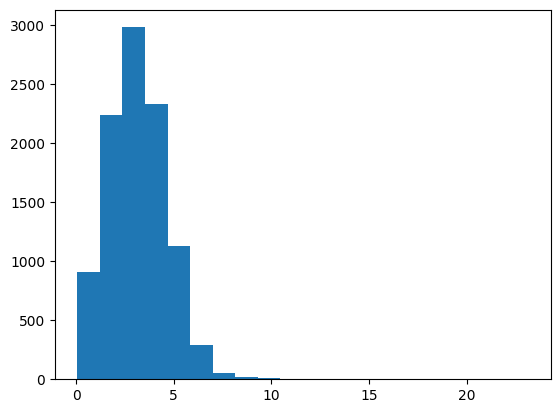

In [137]:
plt.hist(PAIRWISE_CE[np.isfinite(PAIRWISE_CE)], bins=20);

In [82]:
ood_test_samples = [i for i, elem in enumerate(INFS) if elem]

In [83]:
ood_test_samples

[8,
 18,
 33,
 38,
 44,
 62,
 63,
 104,
 115,
 118,
 119,
 122,
 126,
 149,
 151,
 158,
 172,
 175,
 185,
 193,
 195,
 199,
 211,
 225,
 230,
 234,
 241,
 245,
 247,
 255,
 259,
 264,
 266,
 268,
 271,
 278,
 282,
 287,
 303,
 317,
 318,
 321,
 324,
 340,
 341,
 353,
 354,
 358,
 360,
 366,
 373,
 380,
 381,
 402,
 403,
 404,
 412,
 414,
 418,
 420,
 421,
 432,
 443,
 445,
 447,
 448,
 449,
 475,
 479,
 491,
 492,
 495,
 498,
 507,
 523,
 524,
 527,
 530,
 531,
 542,
 543,
 550,
 551,
 562,
 570,
 578,
 579,
 582,
 583,
 613,
 619,
 620,
 627,
 629,
 645,
 646,
 654,
 659,
 667,
 684,
 689,
 691,
 699,
 707,
 708,
 716,
 717,
 720,
 726,
 737,
 740,
 760,
 761,
 786,
 791,
 795,
 797,
 800,
 810,
 830,
 839,
 844,
 853,
 868,
 874,
 882,
 883,
 898,
 900,
 909,
 919,
 922,
 924,
 926,
 938,
 939,
 944,
 947,
 950,
 951,
 956,
 959,
 965,
 992,
 1002,
 1014,
 1032,
 1033,
 1039,
 1044,
 1048,
 1050,
 1052,
 1072,
 1079,
 1089,
 1092,
 1101,
 1107,
 1112,
 1114,
 1124,
 1128,
 1155,
 115

In [141]:
PAIRWISE_CE[ood_test_samples]

array([ 5.0034347,  5.947603 , 22.974333 , ...,  4.2517276,  5.1225986,
        7.5637527], dtype=float32)

In [154]:
PAIRWISE_DIFF = np.array(PAIRWISE_DIFF)

In [159]:
PAIRWISE_DIFF

array([1.2823192 , 1.9844548 , 1.5700442 , ..., 0.6777544 , 0.81922626,
       0.69944257], dtype=float32)

In [160]:
PAIRWISE_DIFF[ood_test_samples]

array([2.114679 , 2.7013144, 2.4483442, ..., 1.7817926, 2.1502101,
       2.9650104], dtype=float32)

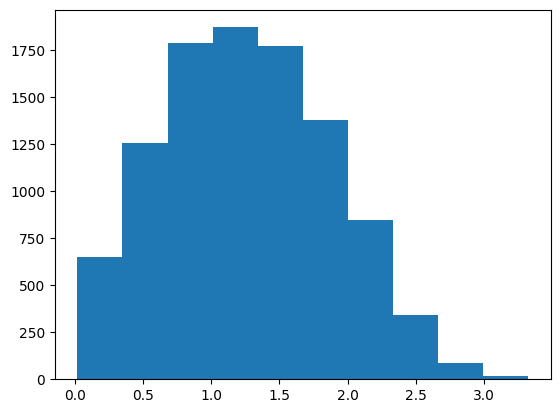

In [164]:
plt.hist(PAIRWISE_DIFF, bins=10);

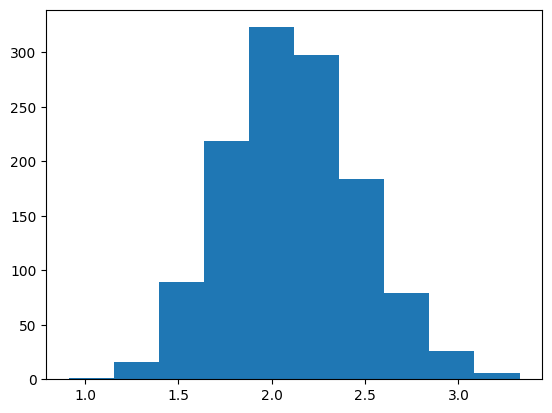

In [165]:
plt.hist(PAIRWISE_DIFF[ood_test_samples], bins=10);

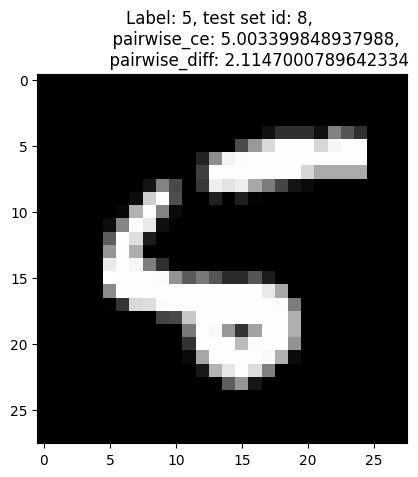

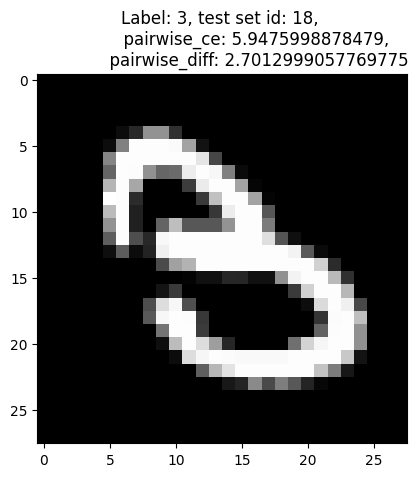

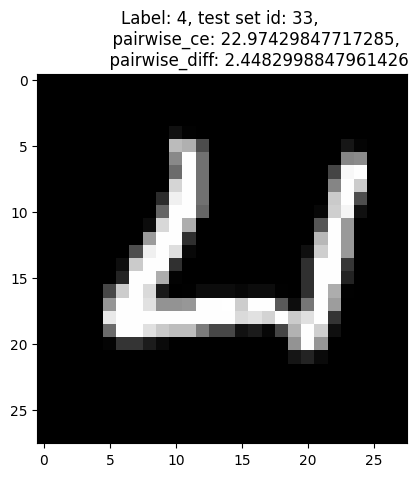

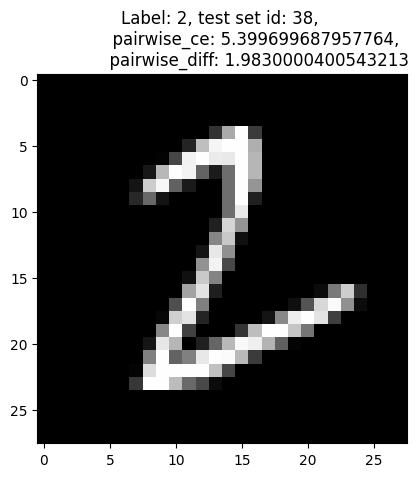

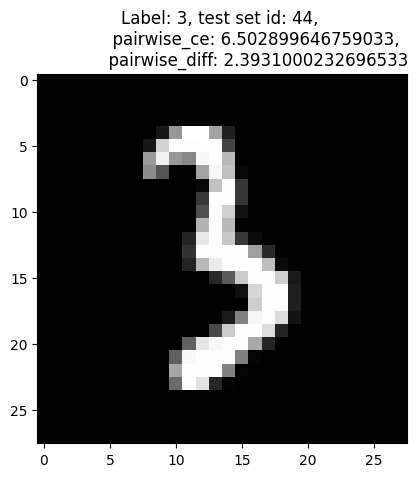

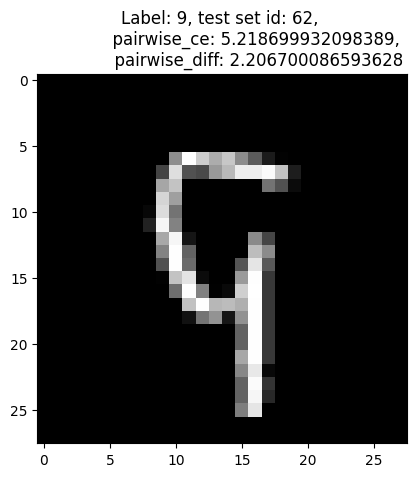

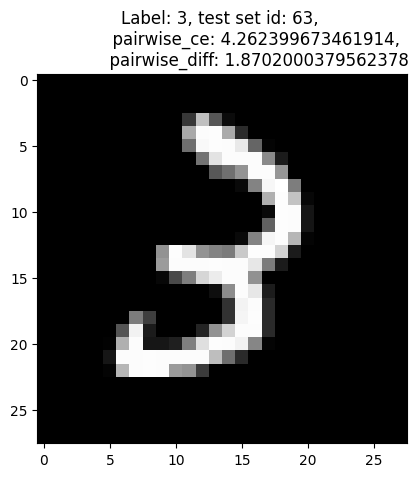

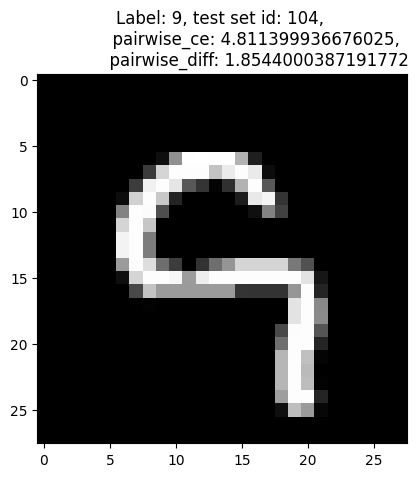

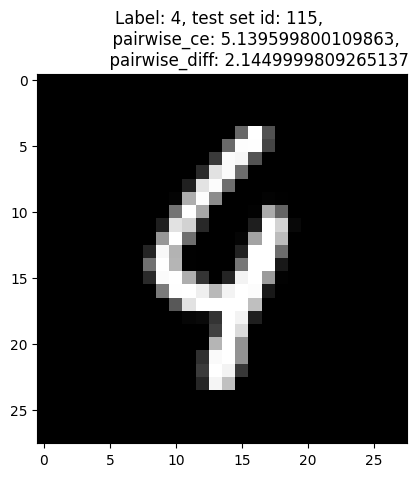

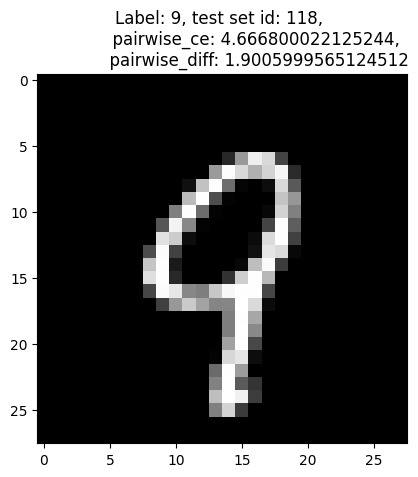

In [166]:
for i in range(10):
    test_id = ood_test_samples[i]
    fig = plt.figure
    plt.imshow(X_test[test_id].reshape(28, 28), cmap='gray')
    plt.title(f"""Label: {y_test[test_id]}, test set id: {test_id}, 
              pairwise_ce: {round(PAIRWISE_CE[test_id], 4)}, 
              pairwise_diff: {round(PAIRWISE_DIFF[test_id], 4)}""")
    plt.show()

In [168]:
arg_max_python_list(PAIRWISE_DIFF)

445

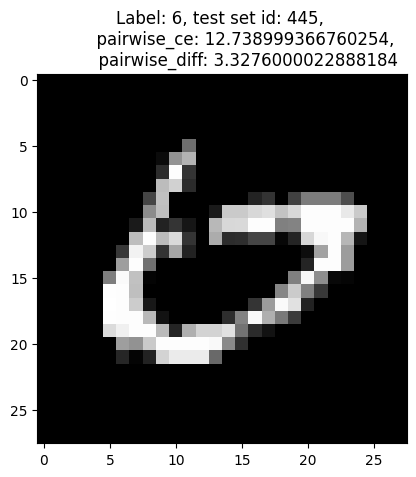

In [170]:
test_id = 445
fig = plt.figure
plt.imshow(X_test[test_id].reshape(28, 28), cmap='gray')
plt.title(f"""Label: {y_test[test_id]}, test set id: {test_id}, 
          pairwise_ce: {round(PAIRWISE_CE[test_id], 4)}, 
          pairwise_diff: {round(PAIRWISE_DIFF[test_id], 4)}""")
plt.show()

In [172]:
arg_min_python_list(PAIRWISE_DIFF)

6311

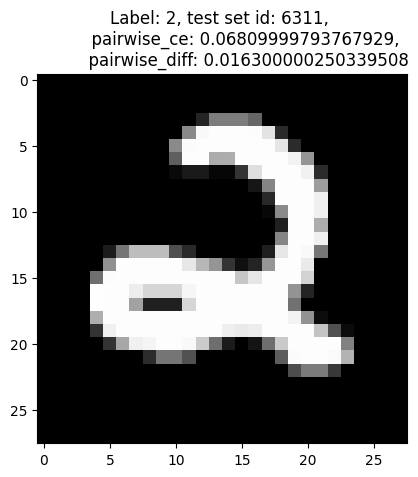

In [173]:
test_id = 6311
fig = plt.figure
plt.imshow(X_test[test_id].reshape(28, 28), cmap='gray')
plt.title(f"""Label: {y_test[test_id]}, test set id: {test_id}, 
          pairwise_ce: {round(PAIRWISE_CE[test_id], 4)}, 
          pairwise_diff: {round(PAIRWISE_DIFF[test_id], 4)}""")
plt.show()

### =======================================================================================

In [49]:
min_mse_df = results_df[results_df.n_members == config.model.size][['model_name', 'random_seed', 'err', 'nll', 'brier']].rename(
    columns={'err': 'final_err', 'nll': 'final_nll', 'brier': 'final_brier'}
)
min_mse_df

,model_name,random_seed,final_err,final_nll,final_brier
30,Prod,0,0.030299999,0.008574387,0.0038716667
61,Ens,0,0.0186,0.059436467,0.0027834233
92,StdProd,0,0.1858,0.0008570069,0.01947


In [51]:
tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
tmp_df['err_diff'] = tmp_df['err'] - tmp_df['final_err'] 
tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
tmp_df['brier_diff'] = tmp_df['brier'] - tmp_df['final_brier'] 
tmp_df

,model_name,n_members,random_seed,H,err,brier,nll,final_err,final_nll,final_brier,err_diff,nll_diff,brier_diff
0,Prod,1,0,0.27698174,0.1301,0.019592168,0.27830294,0.030299999,0.008574387,0.0038716667,0.0998,0.26972854,0.015720502
1,Prod,1,0,0.23602165,0.1413,0.016895046,0.23754257,0.030299999,0.008574387,0.0038716667,0.110999994,0.22896819,0.01302338
2,Prod,1,0,0.78090656,0.3888,0.04817912,0.7809088,0.030299999,0.008574387,0.0038716667,0.3585,0.77233446,0.04430745
3,Prod,1,0,0.1691709,0.1399,0.013757499,0.17152536,0.030299999,0.008574387,0.0038716667,0.1096,0.16295098,0.009885833
4,Prod,1,0,0.8935631,0.5223,0.05355752,0.89348215,0.030299999,0.008574387,0.0038716667,0.492,0.8849078,0.04968585
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,StdProd,4,0,0.0044073737,0.1757,0.018546667,0.005276802,0.1858,0.0008570069,0.01947,-0.010100007,0.0044197952,-0.0009233337
89,StdProd,4,0,0.0019120437,0.1707,0.018196667,0.0022330696,0.1858,0.0008570069,0.01947,-0.015100002,0.0013760627,-0.001273334
90,StdProd,4,0,0.005100521,0.1019,0.011286667,0.005613306,0.1858,0.0008570069,0.01947,-0.083900005,0.0047562993,-0.008183334
91,StdProd,4,0,0.004921345,0.175,0.018465,0.005973956,0.1858,0.0008570069,0.01947,-0.010800004,0.0051169493,-0.0010050014


In [52]:
agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'err_diff': ['mean', 'std', 'count'],
    'err': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
    'brier_diff': ['mean', 'std', 'count'],
    'brier': ['mean', 'std', 'count'],
})
agg_df

H                 err_diff                  \
                          mean       std count     mean       std count   
model_name n_members                                                      
Ens        1          0.046541  0.001245     5  0.00454  0.001244     5   
           2          0.042153  0.000812    10  0.00156  0.000752    10   
           3          0.040580  0.000600    10  0.00066  0.000799    10   
           4          0.039735  0.000438     5  0.00016  0.000532     5   
           5          0.039247       NaN     1  0.00000       NaN     1   
Prod       1          0.471329  0.338585     5  0.23418  0.180747     5   
           2          0.149670  0.130550    10  0.07268  0.069786    10   
           3          0.053908  0.047849    10  0.02154  0.023195    10   
           4          0.020967  0.018513     5  0.00508  0.008244     5   
           5          0.008497       NaN     1  0.00000       NaN     1   
StdProd    1          0.615313  0.063793     5  0.18926  0.039005     5   
           2          0.106020  0.012988    10 -0.04073  0.040255    10   
           3          0.018850  0.003001    10 -0.05034  0.038639    10   
           4          0.003864  0.001372     5 -0.02672  0.032030     5   
           5          0.000693       NaN     1  0.00000       NaN     1   

                          err                  nll_diff  ...             nll  \
                         mean       std count      mean  ... count      mean   
model_name n_members                                     ...                   
Ens        1          0.02314  0.001244     5  0.021186  ...     5  0.080623   
           2          0.02016  0.000752    10  0.008439  ...    10  0.067876   
           3          0.01926  0.000799    10  0.003935  ...    10  0.063372   
           4          0.01876  0.000532     5  0.001582  ...     5  0.061018   
           5          0.01860       NaN     1  0.000000  ...     1  0.059436   
Prod       1          0.26448  0.180747     5  0.463778  ...     5  0.472352   
           2          0.10298  0.069786    10  0.141806  ...    10  0.150381   
           3          0.05184  0.023195    10  0.045766  ...    10  0.054340   
           4          0.03538  0.008244     5  0.012617  ...     5  0.021192   
           5          0.03030       NaN     1  0.000000  ...     1  0.008574   
StdProd    1          0.37506  0.039005     5  0.633056  ...     5  0.633913   
           2          0.14507  0.040255    10  0.114209  ...    10  0.115066   
           3          0.13546  0.038639    10  0.020474  ...    10  0.021331   
           4          0.15908  0.032030     5  0.003685  ...     5  0.004542   
           5          0.18580       NaN     1  0.000000  ...     1  0.000857   

                                     brier_diff                     brier  \
                           std count       mean       std count      mean   
model_name n_members                                                        
Ens        1          0.006413     5   0.000803  0.000164     5  0.003586   
           2          0.004146    10   0.000286  0.000090    10  0.003069   
           3          0.002472    10   0.000116  0.000067    10  0.002900   
           4          0.001387     5   0.000043  0.000045     5  0.002826   
           5               NaN     1   0.000000       NaN     1  0.002783   
Prod       1          0.337582     5   0.026525  0.018898     5  0.030396   
           2          0.130374    10   0.008331  0.007924    10  0.012202   
           3          0.048122    10   0.002490  0.002740    10  0.006361   
           4          0.018657     5   0.000600  0.000876     5  0.004471   
           5               NaN     1   0.000000       NaN     1  0.003872   
StdProd    1          0.078560     5   0.027317  0.007035     5  0.046787   
           2          0.013010    10  -0.000765  0.003925    10  0.018705   
           3          0.003061    10  -0.004271  0.003701    10  0.015199   
     

In [53]:
agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
agg_df[('err_diff', 'std_err')] = agg_df[('err_diff', 'std')] / agg_df[('err_diff', 'count')]
agg_df[('err', 'std_err')] = agg_df[('err', 'std')] / agg_df[('err', 'count')]
agg_df[('nll_diff', 'std_err')] = agg_df[('nll_diff', 'std')] / agg_df[('nll_diff', 'count')]
agg_df[('nll', 'std_err')] = agg_df[('nll', 'std')] / agg_df[('nll', 'count')]
agg_df[('brier_diff', 'std_err')] = agg_df[('brier_diff', 'std')] / agg_df[('brier_diff', 'count')]
agg_df[('brier', 'std_err')] = agg_df[('brier', 'std')] / agg_df[('brier', 'count')]
agg_df

H                 err_diff                  \
                          mean       std count     mean       std count   
model_name n_members                                                      
Ens        1          0.046541  0.001245     5  0.00454  0.001244     5   
           2          0.042153  0.000812    10  0.00156  0.000752    10   
           3          0.040580  0.000600    10  0.00066  0.000799    10   
           4          0.039735  0.000438     5  0.00016  0.000532     5   
           5          0.039247       NaN     1  0.00000       NaN     1   
Prod       1          0.471329  0.338585     5  0.23418  0.180747     5   
           2          0.149670  0.130550    10  0.07268  0.069786    10   
           3          0.053908  0.047849    10  0.02154  0.023195    10   
           4          0.020967  0.018513     5  0.00508  0.008244     5   
           5          0.008497       NaN     1  0.00000       NaN     1   
StdProd    1          0.615313  0.063793     5  0.18926  0.039005     5   
           2          0.106020  0.012988    10 -0.04073  0.040255    10   
           3          0.018850  0.003001    10 -0.05034  0.038639    10   
           4          0.003864  0.001372     5 -0.02672  0.032030     5   
           5          0.000693       NaN     1  0.00000       NaN     1   

                          err                  nll_diff  ...     brier  \
                         mean       std count      mean  ...      mean   
model_name n_members                                     ...             
Ens        1          0.02314  0.001244     5  0.021186  ...  0.003586   
           2          0.02016  0.000752    10  0.008439  ...  0.003069   
           3          0.01926  0.000799    10  0.003935  ...  0.002900   
           4          0.01876  0.000532     5  0.001582  ...  0.002826   
           5          0.01860       NaN     1  0.000000  ...  0.002783   
Prod       1          0.26448  0.180747     5  0.463778  ...  0.030396   
           2          0.10298  0.069786    10  0.141806  ...  0.012202   
           3          0.05184  0.023195    10  0.045766  ...  0.006361   
           4          0.03538  0.008244     5  0.012617  ...  0.004471   
           5          0.03030       NaN     1  0.000000  ...  0.003872   
StdProd    1          0.37506  0.039005     5  0.633056  ...  0.046787   
           2          0.14507  0.040255    10  0.114209  ...  0.018705   
           3          0.13546  0.038639    10  0.020474  ...  0.015199   
           4          0.15908  0.032030     5  0.003685  ...  0.016934   
           5          0.18580       NaN     1  0.000000  ...  0.019470   

                                             H  err_diff       err  nll_diff  \
                           std count   std_err   std_err   std_err   std_err   
model_name n_members                                                           
Ens        1          0.000164     5  0.000249  0.000249  0.000249  0.001283   
           2          0.000090    10  0.000081  0.000075  0.000075  0.000415   
           3          0.000067    10  0.000060  0.000080  0.000080  0.000247   
           4          0.000045     5  0.000088  0.000106  0.000106  0.000277   
           5               NaN     1       NaN       NaN       NaN       NaN   
Prod       1          0.018898     5  0.067717  0.036149  0.036149  0.067516   
           2          0.007924    10  0.013055  0.006979  0.006979  0.013037   
           3          0.002740    10  0.004785  0.002320  0.002320  0.004812   
           4          0.000876     5  0.003703  0.001649  0.001649  0.003731   
           5               NaN     1       NaN       NaN       NaN       NaN   
StdProd    1          0.007035     5  0.012759  0.007801  0.007801  0.015712   
           2          0.003925    10  0.001299  0.004025  0.004025  0.001301   
           3          0.003701    10  0.000300  0.003864  0.003864  0.000306   
           4          0.003161     5  0.000274  0.006406  0.00640

In [57]:
# matplotlib.style.use('default')
fig, axs = plt.subplots(1, 4, figsize=(text_width, text_width/4.), dpi=dpi, sharey=False, sharex=True, layout='tight')

models = ['Prod', 'Ens']
models += ['StdProd']

names = {
    'Prod': 'Ours',
    'Ens': 'DE',
    'StdProd': 'Ours (Std Loss)'
}

linestyles = {
    'Prod': '-',
    'Ens': '--',
    'StdProd': ':',
}

H_df = agg_df['H'].reset_index()
for i, model_name in enumerate(models):
    x = H_df[H_df.model_name == model_name]['n_members']
    y = H_df[H_df.model_name == model_name]['mean']
    y_err = H_df[H_df.model_name == model_name]['std_err']

    axs[0].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5)
    axs[0].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[0].grid(0.3)
axs[0].set_ylabel('$\mathbb{H}$')
axs[0].set_xlabel('$\#$ members')
axs[0].set_xticks(range(1, config.model.size + 1))

err_df = agg_df['brier'].reset_index()
for i, model_name in enumerate(models):
    x = err_df[err_df.model_name == model_name]['n_members']
    y = err_df[err_df.model_name == model_name]['mean']
    y_err = err_df[err_df.model_name == model_name]['std_err']

    axs[2].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5, label=names[model_name])
    axs[2].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[2].grid(0.3)
axs[2].set_ylabel('Brier Score')
axs[2].set_xlabel('$\#$ members')
axs[2].set_xticks(range(1, config.model.size + 1))

err_df = agg_df['err'].reset_index()
for i, model_name in enumerate(models):
    x = err_df[err_df.model_name == model_name]['n_members']
    y = err_df[err_df.model_name == model_name]['mean']
    y_err = err_df[err_df.model_name == model_name]['std_err']

    axs[1].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5, label=names[model_name])
    axs[1].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[1].grid(0.3)
axs[1].set_ylabel('Error')
axs[1].set_xlabel('$\#$ members')
axs[1].set_xticks(range(1, config.model.size + 1))

nll_df = agg_df[f'nll'].reset_index()
for i, model_name in enumerate(models):
    x = nll_df[nll_df.model_name == model_name]['n_members']
    y = nll_df[nll_df.model_name == model_name]['mean']
    y_err = nll_df[nll_df.model_name == model_name]['std_err']

    axs[3].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1., alpha=0.5, label=names[model_name])
    axs[3].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[3].grid(0.2)
axs[3].set_ylabel(f'NLL')
axs[3].set_xlabel('$\#$ members')
axs[3].set_xticks(range(1, config.model.size + 1))
axs[3].legend()

plt.savefig(f'mnist_entropy_err_nll_evolution.pdf', dpi=dpi, bbox_inches='tight')

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7f38993c7e50> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2700.53x675.133 with 4 Axes>